In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from statsmodels.tsa.api import ExponentialSmoothing
#from pmdarima import auto_arima

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm
import warnings

In [ ]:

# Load Dataset
sales_path = '/content/drive/MyDrive/malaya/honda_sales.csv'
split = 18
sales = pd.read_csv(sales_path)

print("Shape of dataset:", sales.shape)

sales['date'] = pd.to_datetime(sales['date'])
sales.set_index('date', inplace=True)
sales = sales.asfreq('MS')  # MS = Month Start
sales = sales.sort_index()

sales.head()

Shape of dataset: (246, 2)


,sales
date,
2005-01-01,67480.0
2005-02-01,81979.0
2005-03-01,109949.0
2005-04-01,116495.0
2005-05-01,103486.0


In [ ]:
# #Google trends


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trends = pd.read_csv('/content/drive/MyDrive/malaya/google_trends.csv')
trends['month'] = pd.to_datetime(trends['month'])
trends.set_index('month', inplace=True)
trends = trends.asfreq('MS')  # MS = Month Start
trends = trends.sort_index()
sales['trend'] = trends['trend']


In [ ]:
trends

,trend
month,
2005-01-01,65
2005-02-01,65
2005-03-01,76
2005-04-01,82
2005-05-01,78
...,...
2025-02-01,67
2025-03-01,75
2025-04-01,71


In [ ]:
sales

,sales,trend
date,,
2005-01-01,67480.0,65
2005-02-01,81979.0,65
2005-03-01,109949.0,76
2005-04-01,116495.0,82
2005-05-01,103486.0,78
...,...,...
2025-02-01,97688.0,67
2025-03-01,135040.0,75
2025-04-01,123637.0,71


In [ ]:
#roBerta sentiment analysis data
tweets = pd.read_csv('/content/drive/MyDrive/malaya/filtered_tweets_with_sentiment.csv', parse_dates=['Date'])
# tweets['date'] = pd.to_datetime(tweets['Date'])
# tweets.set_index('date', inplace=True)
# tweets = tweets.sort_index()
tweets.head()

,Text,Date,Retweets,Likes,sentiment,sentiment_score
0,Skeletor says to purchase the @BrickellHonda C...,2015-01-01 22:08:01+00:00,0,0,1,0
1,Congrats to Linda Molhollen of Henderson NC on...,2015-01-01 21:51:20+00:00,0,0,2,1
2,New post: New 2015 Honda Civic Hybrid for sale...,2015-01-01 20:13:18+00:00,0,0,1,0
3,Get your #honda #repair manuals http://t.co/0G...,2015-01-01 23:43:16+00:00,0,0,1,0
4,"If Skeletor had eyes, they’d be set on the CR-...",2015-01-01 21:36:02+00:00,0,0,1,0


In [ ]:
#Vader and textBlob data
# vtb = pd.read_csv('/content/drive/MyDrive/malaya/vader_tb_sentiment.csv', index_col=0, parse_dates=True)
# vtb

In [ ]:
# for i in vtb.columns:
#   df[i] = vtb[i]

In [ ]:
# Cell 3: Dedicated Feature Engineering

print("--- Running Dedicated Feature Engineering Cell ---")

# (All feature engineering logic from the previous final version)
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
if tweets.index.name != 'Date': tweets.set_index('Date', inplace=True)
sentiment_map = {0: -1, 1: 0, 2: 1}
tweets['sentiment_numeric'] = tweets['sentiment'].map(sentiment_map)
if tweets['sentiment_score'].min() < 0:
    # score already includes polarity
    tweets['weighted_sentiment'] = tweets['sentiment_score']
else:
    # score is just confidence, need to weight with sentiment polarity
    tweets['weighted_sentiment'] = tweets['sentiment'] * tweets['sentiment_score']
positive_confidence = (
    tweets[tweets['sentiment'] == 2]
    .resample('MS')['sentiment_score']
    .mean()
    .rename('Avg_Positive_Confidence')
)
negative_confidence = (
    tweets[tweets['sentiment'] == 0]
    .resample('MS')['sentiment_score']
    .mean()
    .rename('Avg_Negative_Confidence')
)
weighted_mean = (
    tweets.resample('MS')['weighted_sentiment']
    .mean()
    .rename('Weighted_Sentiment_Mean')
)

#positive_confidence = tweets[tweets['sentiment'] == 1].resample('MS')['sentiment_score'].mean().rename('Avg_Positive_Confidence')
#weighted_mean = tweets[tweets['sentiment'] == 1].resample('MS')['weighted_sentiment'].mean().rename('Weighted_Sentiment_Mean')
tweet_count = tweets.resample('MS').size().rename('Tweet_Count')
sentiment_mean = (
    tweets.resample('MS')['sentiment_numeric']
    .mean()
    .rename('Unweighted_Sentiment_Mean')
)
#sentiment_mean = tweets[tweets['sentiment'] == 1].resample('MS')['sentiment'].mean().rename('Unweighted_Sentiment_Mean')
base_features = pd.concat([positive_confidence, negative_confidence, weighted_mean, tweet_count, sentiment_mean], axis=1)
date_index = base_features.index



print("\nDecomposing sales data with Holt-Winters...")
if 'date' in sales.columns:
    sales['date'] = pd.to_datetime(sales['date'])  # convertit en datetime
    sales_ts = sales.set_index('date')['sales']
else:
    sales_ts = sales['sales']



monthly_sentiment_features = base_features
monthly_sentiment_features.fillna(0, inplace=True)
print("\nAll features engineered successfully.")

--- Running Dedicated Feature Engineering Cell ---

Decomposing sales data with Holt-Winters...

All features engineered successfully.


In [ ]:
sales

,sales,trend
date,,
2005-01-01,67480.0,65
2005-02-01,81979.0,65
2005-03-01,109949.0,76
2005-04-01,116495.0,82
2005-05-01,103486.0,78
...,...,...
2025-02-01,97688.0,67
2025-03-01,135040.0,75
2025-04-01,123637.0,71


In [ ]:
# monthly_sentiment_features

In [ ]:
sales.index = sales.index.tz_localize(None)
monthly_sentiment_features.index = monthly_sentiment_features.index.tz_localize(None)
sentiment_features = [i for i in monthly_sentiment_features.columns]
sales[sentiment_features] = monthly_sentiment_features[sentiment_features]

In [ ]:
sales

,sales,trend,Avg_Positive_Confidence,Avg_Negative_Confidence,Weighted_Sentiment_Mean,Tweet_Count,Unweighted_Sentiment_Mean
date,,,,,,,
2005-01-01,67480.0,65,NaN,NaN,NaN,NaN,NaN
2005-02-01,81979.0,65,NaN,NaN,NaN,NaN,NaN
2005-03-01,109949.0,76,NaN,NaN,NaN,NaN,NaN
2005-04-01,116495.0,82,NaN,NaN,NaN,NaN,NaN
2005-05-01,103486.0,78,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-02-01,97688.0,67,1.000000,-0.500000,0.682203,236.0,0.474576
2025-03-01,135040.0,75,0.889831,-0.733333,0.473913,230.0,0.382609
2025-04-01,123637.0,71,0.966942,-0.607143,0.585903,227.0,0.409692


In [ ]:
# sales['month'] = sales.index.month
# sales.dropna(inplace=True)
df = sales
df

,sales,trend,Avg_Positive_Confidence,Avg_Negative_Confidence,Weighted_Sentiment_Mean,Tweet_Count,Unweighted_Sentiment_Mean
date,,,,,,,
2005-01-01,67480.0,65,NaN,NaN,NaN,NaN,NaN
2005-02-01,81979.0,65,NaN,NaN,NaN,NaN,NaN
2005-03-01,109949.0,76,NaN,NaN,NaN,NaN,NaN
2005-04-01,116495.0,82,NaN,NaN,NaN,NaN,NaN
2005-05-01,103486.0,78,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-02-01,97688.0,67,1.000000,-0.500000,0.682203,236.0,0.474576
2025-03-01,135040.0,75,0.889831,-0.733333,0.473913,230.0,0.382609
2025-04-01,123637.0,71,0.966942,-0.607143,0.585903,227.0,0.409692


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression



# # Ensure datetime index
# df.index = pd.to_datetime(df.index)

# for i in sentiment_features:
#   # Identify missing at the beginning
#   missing = df[df[i].isna()]
#   known = df[df[i].notna()]

#   # Only extrapolate if we have known data
#   if not known.empty and not missing.empty:
#       # Convert time to numeric for regression
#       X_known = (known.index - known.index[0]).days.values.reshape(-1, 1)
#       y_known = known[i].values

#       # Fit linear model
#       model = LinearRegression()
#       model.fit(X_known, y_known)

#       # Prepare X for missing dates
#       X_missing = (missing.index - known.index[0]).days.values.reshape(-1, 1)

#       # Predict missing values
#       extrapolated_values = model.predict(X_missing)

#       # Fill in
#       df.loc[missing.index, i] = extrapolated_values


In [ ]:

# # sales.ffill(inplace=True); sales.bfill(inplace=True); sales.fillna(0, inplace=True)
df = sales.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')

/tmp/ipython-input-3694972154.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = sales.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')


In [ ]:
df

,sales,trend,Avg_Positive_Confidence,Avg_Negative_Confidence,Weighted_Sentiment_Mean,Tweet_Count,Unweighted_Sentiment_Mean
date,,,,,,,
2005-01-01,67480.0,65,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-02-01,81979.0,65,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-03-01,109949.0,76,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-04-01,116495.0,82,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-05-01,103486.0,78,0.000000,-1.000000,-1.000000,1.0,-1.000000
...,...,...,...,...,...,...,...
2025-02-01,97688.0,67,1.000000,-0.500000,0.682203,236.0,0.474576
2025-03-01,135040.0,75,0.889831,-0.733333,0.473913,230.0,0.382609
2025-04-01,123637.0,71,0.966942,-0.607143,0.585903,227.0,0.409692


In [ ]:
features_to_lag = [
                  'trend',
                  'Tweet_Count',
                  'Avg_Positive_Confidence',
                  'Weighted_Sentiment_Mean',
                  'Unweighted_Sentiment_Mean',
                  'Avg_Negative_Confidence',
]
print(f"\n--- Lagging features by 2 month for true forecasting: {features_to_lag} ---")
df[features_to_lag] = df[features_to_lag].shift(2)


--- Lagging features by 2 month for true forecasting: ['trend', 'Tweet_Count', 'Avg_Positive_Confidence', 'Weighted_Sentiment_Mean', 'Unweighted_Sentiment_Mean', 'Avg_Negative_Confidence'] ---


In [ ]:
df

,sales,trend,Avg_Positive_Confidence,Avg_Negative_Confidence,Weighted_Sentiment_Mean,Tweet_Count,Unweighted_Sentiment_Mean
date,,,,,,,
2005-01-01,67480.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-01,81979.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-01,109949.0,65.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-04-01,116495.0,65.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-05-01,103486.0,76.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
...,...,...,...,...,...,...,...
2025-02-01,97688.0,67.0,0.991453,-0.550000,0.548077,208.0,0.466346
2025-03-01,135040.0,66.0,0.973154,-0.800000,0.441781,292.0,0.321918
2025-04-01,123637.0,67.0,1.000000,-0.500000,0.682203,236.0,0.474576


In [ ]:
df.dropna(inplace=True)
df

,sales,trend,Avg_Positive_Confidence,Avg_Negative_Confidence,Weighted_Sentiment_Mean,Tweet_Count,Unweighted_Sentiment_Mean
date,,,,,,,
2005-03-01,109949.0,65.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-04-01,116495.0,65.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-05-01,103486.0,76.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-06-01,114672.0,82.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-07-01,123308.0,78.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
...,...,...,...,...,...,...,...
2025-02-01,97688.0,67.0,0.991453,-0.550000,0.548077,208.0,0.466346
2025-03-01,135040.0,66.0,0.973154,-0.800000,0.441781,292.0,0.321918
2025-04-01,123637.0,67.0,1.000000,-0.500000,0.682203,236.0,0.474576


In [ ]:
train_size = int(len(sales) - split)


In [ ]:
# features = ['trend',
#             'Tweet_Count',
#             'Avg_Positive_Confidence',
#             'Weighted_Sentiment_Mean',
#             'Unweighted_Sentiment_Mean',
#             'month', 'is_pandemic',
#             #Real_GDP', 'Unemployment_Rate', 'Consumer_Sentiment', 'New_Vehicle_CPI', 'Overall_CPI', 'Gasoline_CPI', 'Auto_Loan_Rate_48mo', 'Model_Release_Hype', 'New_Model_Impact'
#             ]

                                        SARIMAX Results                                        
Dep. Variable:                                   sales   No. Observations:                  228
Model:             SARIMAX(2, 1, 1)x(3, 1, [1, 2], 12)   Log Likelihood               -2406.312
Date:                                 Sun, 24 Aug 2025   AIC                           4830.624
Time:                                         15:33:13   BIC                           4860.959
Sample:                                     01-01-2005   HQIC                          4842.881
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1777      0.432      0.411      0.681      -0.670       1

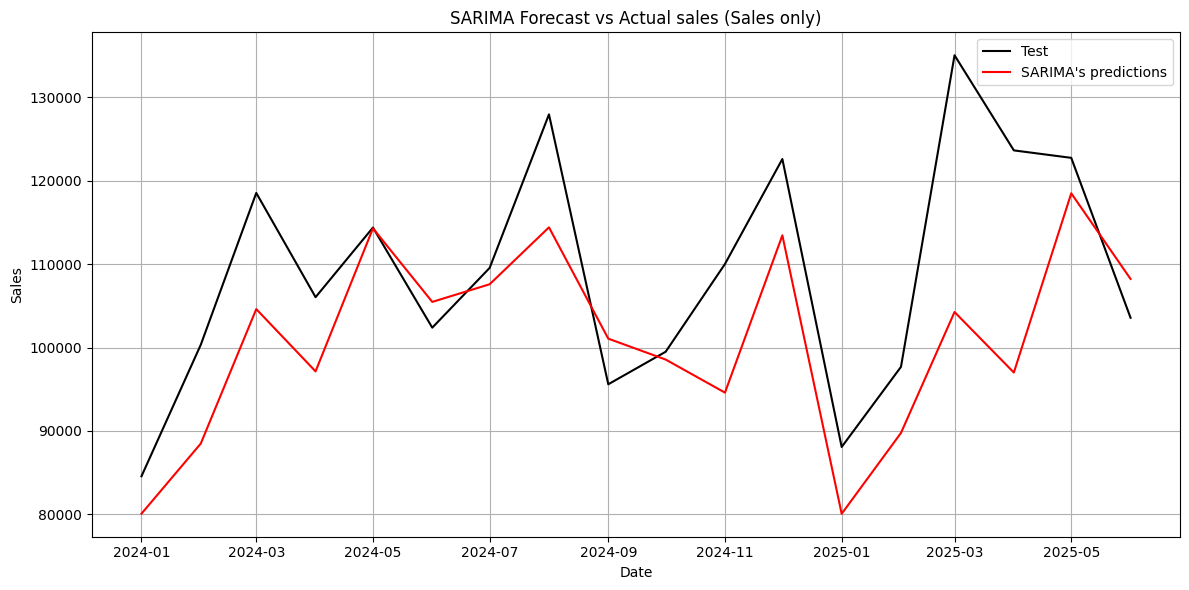

In [ ]:
train, test = sales.iloc[:train_size], sales.iloc[train_size:]


# Model
model = SARIMAX(train['sales'], order=(2,1,1), seasonal_order=(3,1,2,12))
results = model.fit(disp=False)


predictions = results.predict(start=test.index[0], end=test.index[-1])

#Evaluation
rmse = root_mean_squared_error(test['sales'], predictions)
r2 = r2_score(test['sales'], predictions)
mae = mean_absolute_error(test['sales'], predictions)
mape = mean_absolute_percentage_error(test['sales'], predictions)
print(results.summary())
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²: {r2:.2%}")


#Visualization
plt.figure(figsize=(12,6))
plt.plot(test.index, test['sales'], label='Test', color='black')
plt.plot(predictions.index, predictions, label='SARIMA\'s predictions', color='red')
plt.title("SARIMA Forecast vs Actual sales (Sales only)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                               sales_log   No. Observations:                  228
Model:             SARIMAX(2, 1, 1)x(3, 1, [1, 2], 12)   Log Likelihood                 110.788
Date:                                 Sun, 24 Aug 2025   AIC                           -203.576
Time:                                         15:33:30   BIC                           -173.241
Sample:                                     01-01-2005   HQIC                          -191.319
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5333      0.076      7.058      0.000       0.385       0

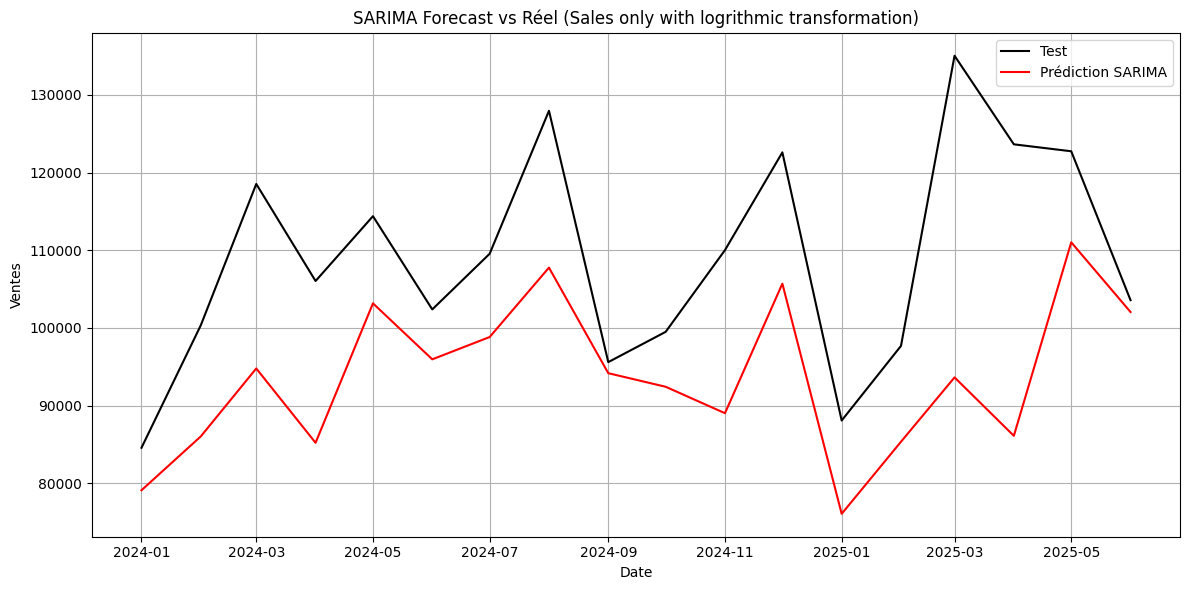

In [ ]:
#logartithmic transformation
sales['sales_log'] = np.log(sales['sales'] + 1)
train, test = sales.iloc[:train_size], sales.iloc[train_size:]

# Model
model = SARIMAX(train['sales_log'], order=(2,1,1), seasonal_order=(3,1,2,12))
results = model.fit(disp=False)




start_index = test.index.min()
end_index = test.index.max()
predictions_log = results.predict(start=start_index, end=end_index)
predictions = np.exp(predictions_log) - 1



#Evaluation
rmse = root_mean_squared_error(test['sales'], predictions)
r2 = r2_score(test['sales'], predictions)
mae = mean_absolute_error(test['sales'], predictions)
mape = mean_absolute_percentage_error(test['sales'], predictions)
print(results.summary())
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"R²: {r2:.2%}")


#Visualization
plt.figure(figsize=(12,6))
plt.plot(test.index, test['sales'], label='Test', color='black')
plt.plot(predictions.index, predictions, label='Prédiction SARIMA', color='red')
plt.title("SARIMA Forecast vs Réel (Sales only with logrithmic transformation)")
plt.xlabel("Date")
plt.ylabel("Ventes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
rhh=results.predict(start = "2025-07-01", end ="2025-07-01")
rhh

,0
2025-07-01,11.532019


In [ ]:
rhh = np.exp(rhh) - 1
rhh

,0
2025-07-01,101926.717903


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                               sales_log   No. Observations:                  228
Model:             SARIMAX(4, 1, 1)x(3, 1, [1, 2], 12)   Log Likelihood                 113.521
Date:                                 Sun, 24 Aug 2025   AIC                           -203.042
Time:                                         15:33:55   BIC                           -162.595
Sample:                                     01-01-2005   HQIC                          -186.699
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
is_pandemic    -0.2982      0.040     -7.423      0.000      -0.377     

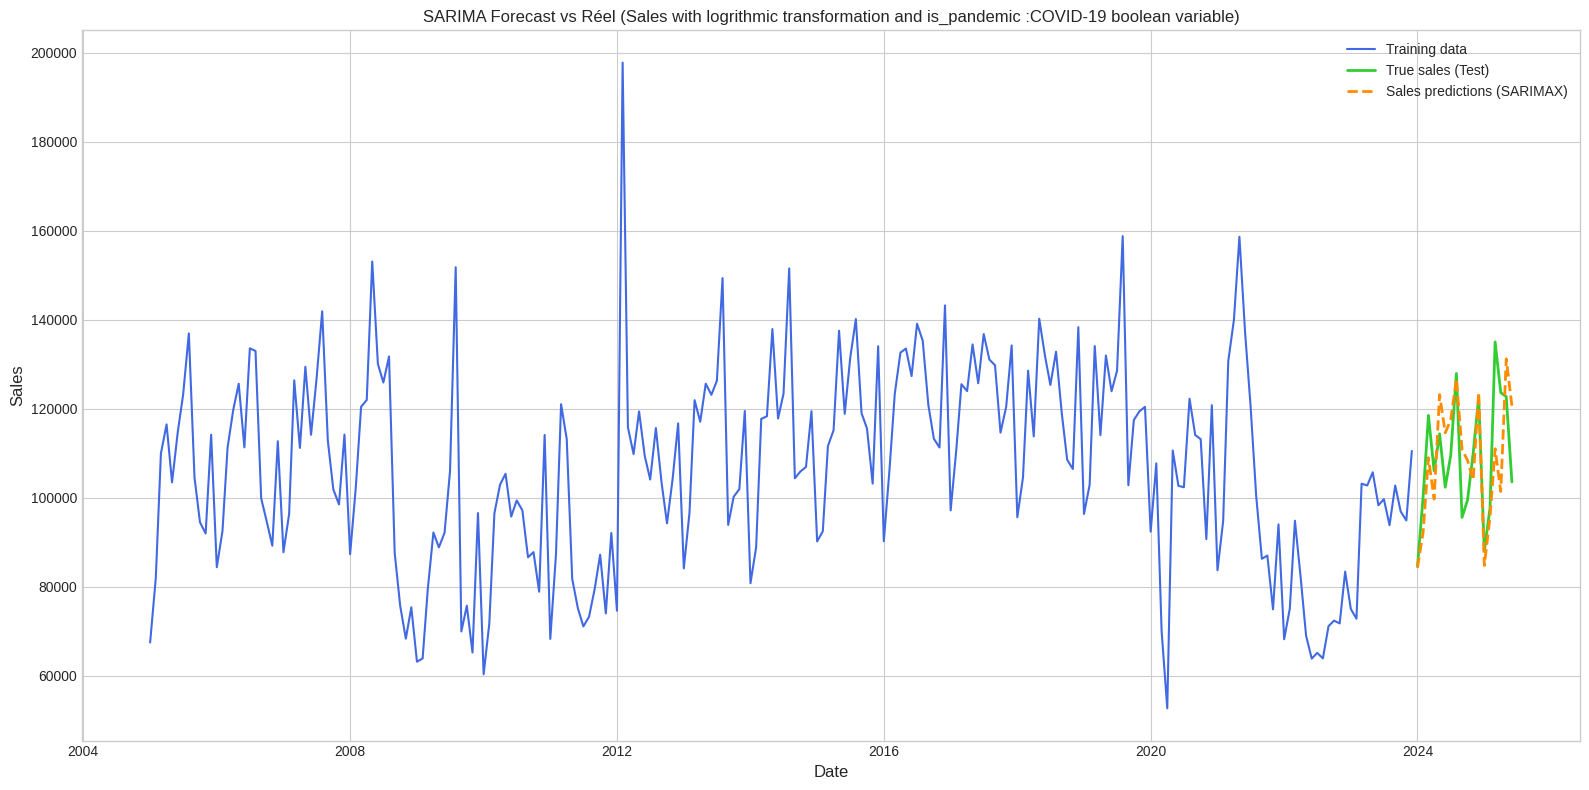

In [ ]:
#logartithmic transformation
#df['sales_log'] = np.log(df['sales'] + 1)

#Creation of Exogenous Variables:
 #Variable: is_pandemic =>  To explain COVID-19 effect

pandemic_start = '2020-03-01'
pandemic_end = '2020-12-31'
sales['is_pandemic'] = 0
sales.loc[pandemic_start:pandemic_end, 'is_pandemic'] = 1



exog_variables = [
    "is_pandemic",
]

train, test = sales.iloc[:train_size], sales.iloc[train_size:]

X_train = train[exog_variables]
X_test = test[exog_variables]
y_train = train['sales_log']
y_test = test['sales']

# Model
model = SARIMAX(y_train, exog=train[exog_variables], order=(4,1,1), seasonal_order=(3,1,2,12))
results = model.fit(disp=False)


start_index = test.index.min()
end_index = test.index.max()
predictions_log = results.predict(start=start_index, end=end_index, exog=X_test)
predictions = np.exp(predictions_log) - 1



#Evaluation
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(results.summary())
print(f"\nRMSE: {rmse:.2f}")
print(f"\nMAE: {mae:.2f}")
print(f"\nMAPE: {mape:.2%}")
print(f"\nR²: {r2:.2%}")


#Visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))
plt.plot(train['sales'], label='Training data', color='royalblue')
plt.plot(y_test, label='True sales (Test)', color='limegreen', linewidth=2)
plt.plot(predictions, label='Sales predictions (SARIMAX)', color='darkorange', linestyle='--', linewidth=2)
plt.title("SARIMA Forecast vs Réel (Sales with logrithmic transformation and is_pandemic :COVID-19 boolean variable)")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                          sales_log   No. Observations:                  228
Model:             SARIMAX(4, 1, 1)x(3, 1, 1, 12)   Log Likelihood                 115.508
Date:                            Sun, 24 Aug 2025   AIC                           -207.015
Time:                                    15:34:17   BIC                           -166.568
Sample:                                01-01-2005   HQIC                          -190.673
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
is_pandemic       -0.2982      0.040     -7.513      0.000      -0.376      -0.220
is_crisis_2008     0.16

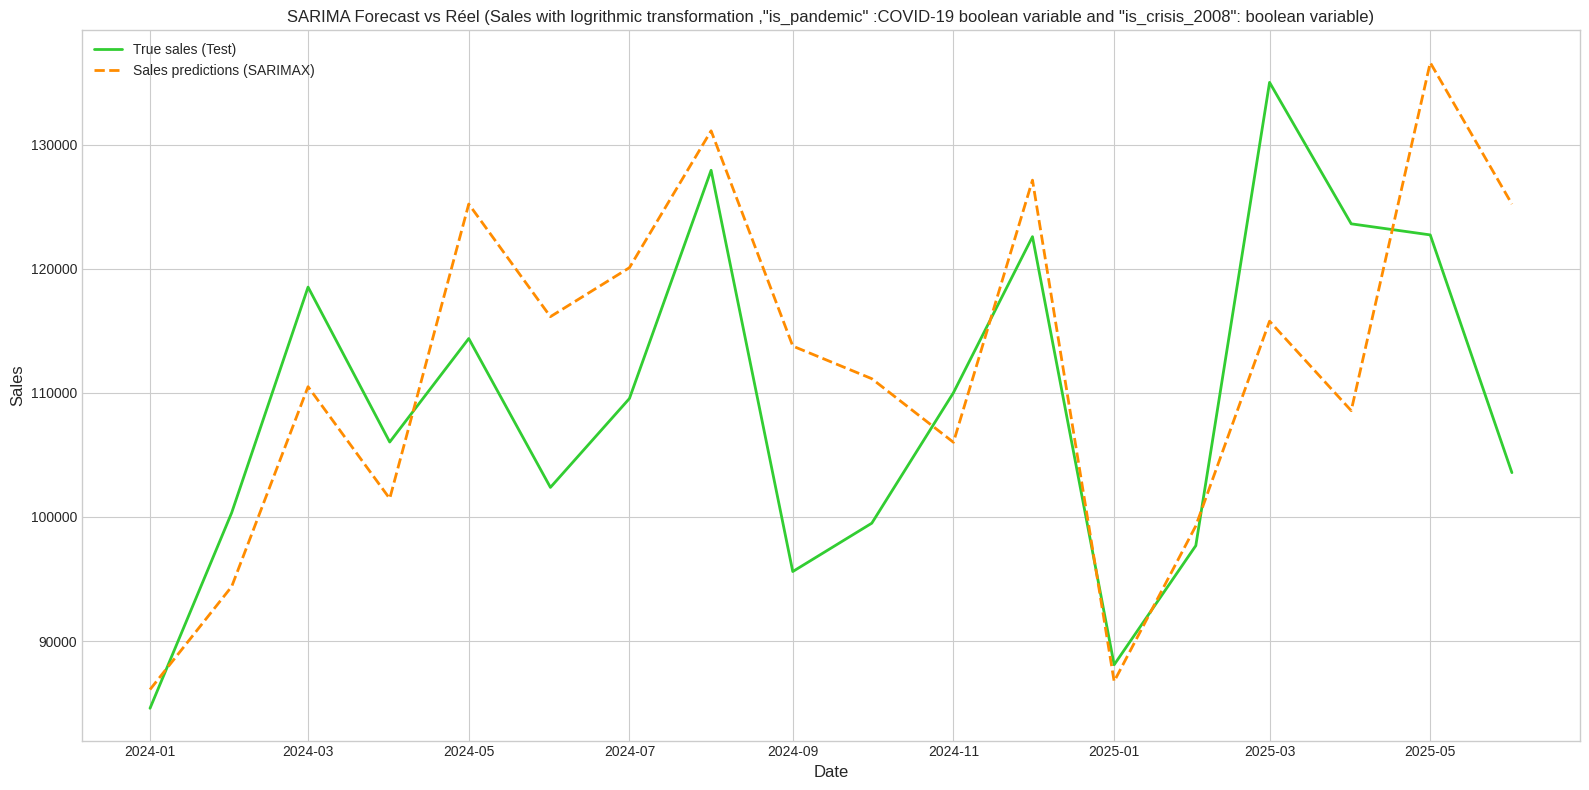

In [ ]:
#logartithmic transformation
#df['sales_log'] = np.log(df['sales'] + 1)

#Creation of Exogenous Variables:
 # Variable: is_pandemic =>  To explain COVID-19 effect

pandemic_start = '2020-03-01'
pandemic_end = '2020-12-31'
sales['is_pandemic'] = 0
sales.loc[pandemic_start:pandemic_end, 'is_pandemic'] = 1

 # Variable: is_crisis_2008 => To explain the financial crisis in 2008
crisis_start = '2008-01-01'
crisis_end = '2009-08-01'
sales['is_crisis_2008'] = 0
sales.loc[crisis_start:crisis_end, 'is_crisis_2008'] = 1



exog_variables = ['is_pandemic', 'is_crisis_2008']



train, test = sales.iloc[:train_size], sales.iloc[train_size:]


X_train = train[exog_variables]
X_test = test[exog_variables]
y_train = train['sales_log']
y_test = test['sales']

# Model
model = SARIMAX(y_train, exog=train[exog_variables], order=(4,1,1), seasonal_order=(3,1,1,12))
results = model.fit(disp=False)


start_index = test.index.min()
end_index = test.index.max()
predictions_log = results.predict(start=start_index, end=end_index, exog=X_test)
predictions = np.exp(predictions_log) - 1



#Evaluation
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(results.summary())
print(f"\nRMSE: {rmse:.2f}")
print(f"\nMAE: {mae:.2f}")
print(f"\nMAPE: {mape:.2%}")
print(f"\nR²: {r2:.2%}")


#Visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='True sales (Test)', color='limegreen', linewidth=2)
plt.plot(predictions, label='Sales predictions (SARIMAX)', color='darkorange', linestyle='--', linewidth=2)
plt.title('SARIMA Forecast vs Réel (Sales with logrithmic transformation ,"is_pandemic" :COVID-19 boolean variable and "is_crisis_2008": boolean variable)')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                               sales_log   No. Observations:                  228
Model:             SARIMAX(4, 1, 1)x(3, 1, [1, 2], 12)   Log Likelihood                 125.577
Date:                                 Sun, 24 Aug 2025   AIC                           -223.154
Time:                                         15:34:45   BIC                           -175.965
Sample:                                     01-01-2005   HQIC                          -204.087
                                          - 12-01-2023                                         
Covariance Type:                                robust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
is_pandemic       -0.2069      0.159     -1.302      0.193      -0

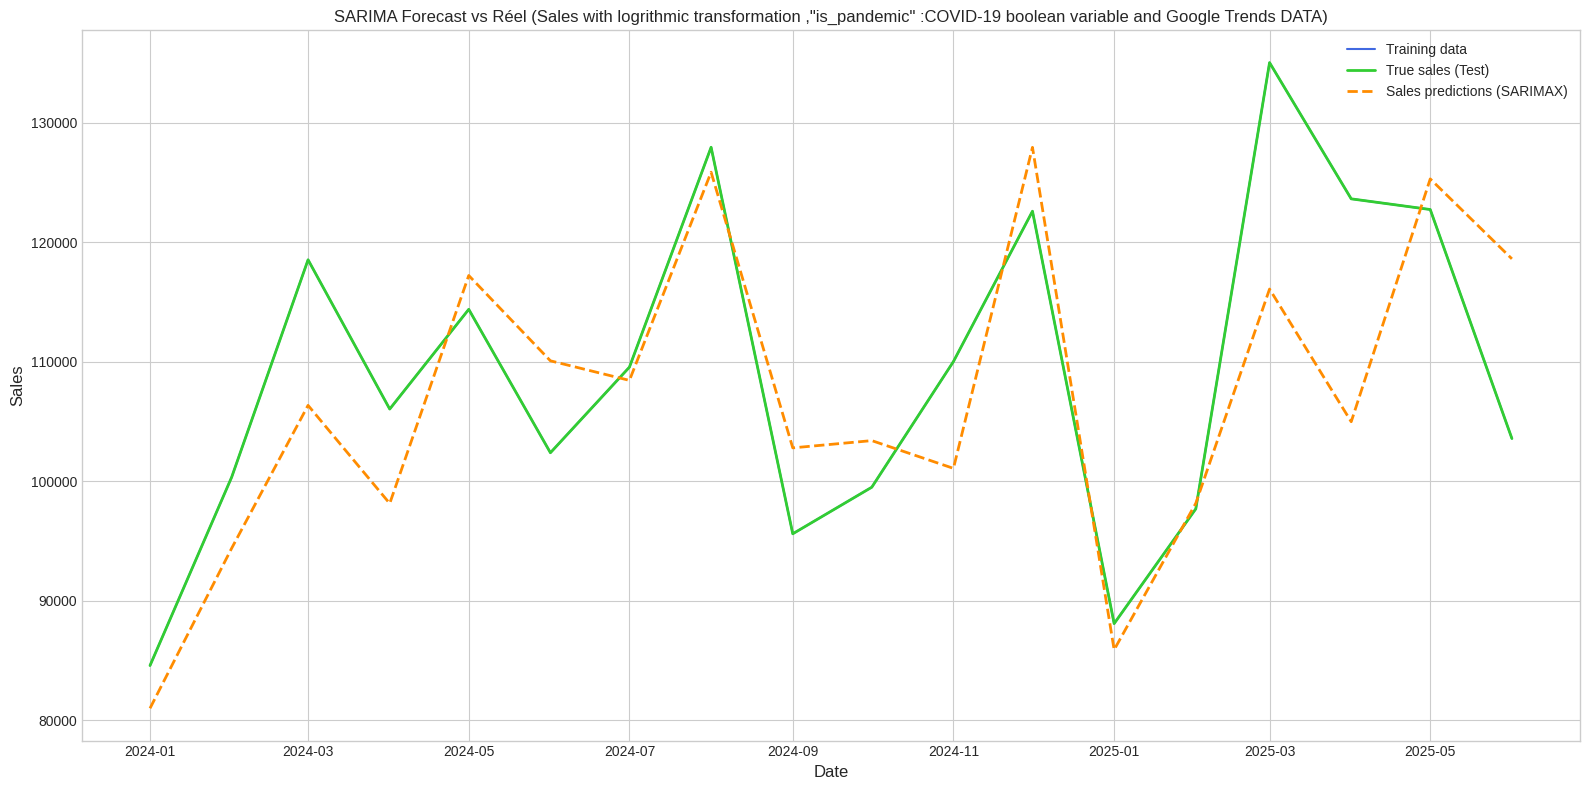

In [ ]:
#logartithmic transformation
sales['sales_log'] = np.log(sales['sales']+1)

#Creation of Exogenous Variables:
 # Variable: is_pandemic =>  To explain COVID-19 effect

pandemic_start = '2020-03-01'
pandemic_end = '2020-12-31'
sales['is_pandemic'] = 0
sales.loc[pandemic_start:pandemic_end, 'is_pandemic'] = 1

 # Variable: is_crisis_2008 => To explain the financial crisis in 2008
crisis_start = '2008-01-01'
crisis_end = '2009-08-01'
sales['is_crisis_2008'] = 0
sales.loc[crisis_start:crisis_end, 'is_crisis_2008'] = 1



exog_variables = ['is_pandemic', 'trend', 'is_crisis_2008',]



train, test = sales.iloc[:train_size], sales.iloc[train_size:]


X_train = train[exog_variables]
X_test = test[exog_variables]
y_train = train['sales_log']
y_test = test['sales']

# Model
model = SARIMAX(y_train, exog=train[exog_variables], order=(4,1,1), seasonal_order=(3,1,2,12),)
results = model.fit(disp=False, cov_type='robust', maxiter=50)


start_index = test.index.min()
end_index = test.index.max()
predictions_log = results.predict(start=start_index, end=end_index, exog=X_test)
predictions = np.exp(predictions_log) - 1

final_pred_sarimax = predictions
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#Evaluation
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = calculate_mape(y_test, predictions)
print(results.summary())
print(f"\nRMSE: {rmse:.2f}")
print(f"\nMAE: {mae:.2f}")
print(f"\nMAPE: {mape:.2f}%")
print(f"\nR²: {r2:.2%}")


#Visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))
plt.plot(test['sales'], label='Training data', color='royalblue')
plt.plot(y_test, label='True sales (Test)', color='limegreen', linewidth=2)
plt.plot(predictions, label='Sales predictions (SARIMAX)', color='darkorange', linestyle='--', linewidth=2)
plt.title('SARIMA Forecast vs Réel (Sales with logrithmic transformation ,"is_pandemic" :COVID-19 boolean variable and Google Trends DATA)')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

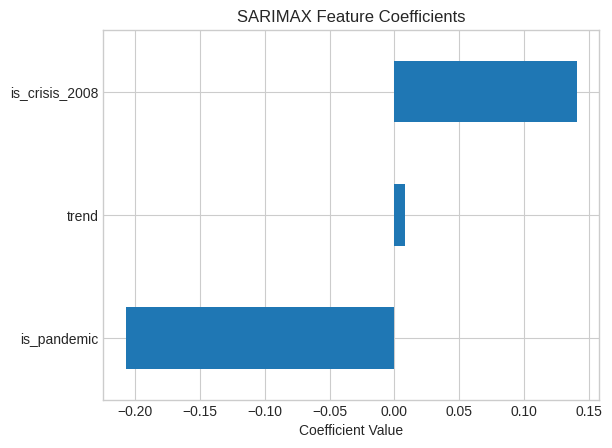

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

coef = results.params[exog_variables]  # Get coefficients for exogenous variables
coef.plot(kind='barh', title='SARIMAX Feature Coefficients')
plt.xlabel("Coefficient Value")
plt.show()


In [ ]:
df

,sales,trend,Avg_Positive_Confidence,Avg_Negative_Confidence,Weighted_Sentiment_Mean,Tweet_Count,Unweighted_Sentiment_Mean
date,,,,,,,
2005-03-01,109949.0,65.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-04-01,116495.0,65.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-05-01,103486.0,76.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-06-01,114672.0,82.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
2005-07-01,123308.0,78.0,0.000000,-1.000000,-1.000000,1.0,-1.000000
...,...,...,...,...,...,...,...
2025-02-01,97688.0,67.0,0.991453,-0.550000,0.548077,208.0,0.466346
2025-03-01,135040.0,66.0,0.973154,-0.800000,0.441781,292.0,0.321918
2025-04-01,123637.0,67.0,1.000000,-0.500000,0.682203,236.0,0.474576


                                        SARIMAX Results                                        
Dep. Variable:                               sales_log   No. Observations:                  226
Model:             SARIMAX(4, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 113.812
Date:                                 Sun, 24 Aug 2025   AIC                           -195.624
Time:                                         15:35:04   BIC                           -141.844
Sample:                                     03-01-2005   HQIC                          -173.890
                                          - 12-01-2023                                         
Covariance Type:                                robust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
is_pandemic                -0.3199      0.187   

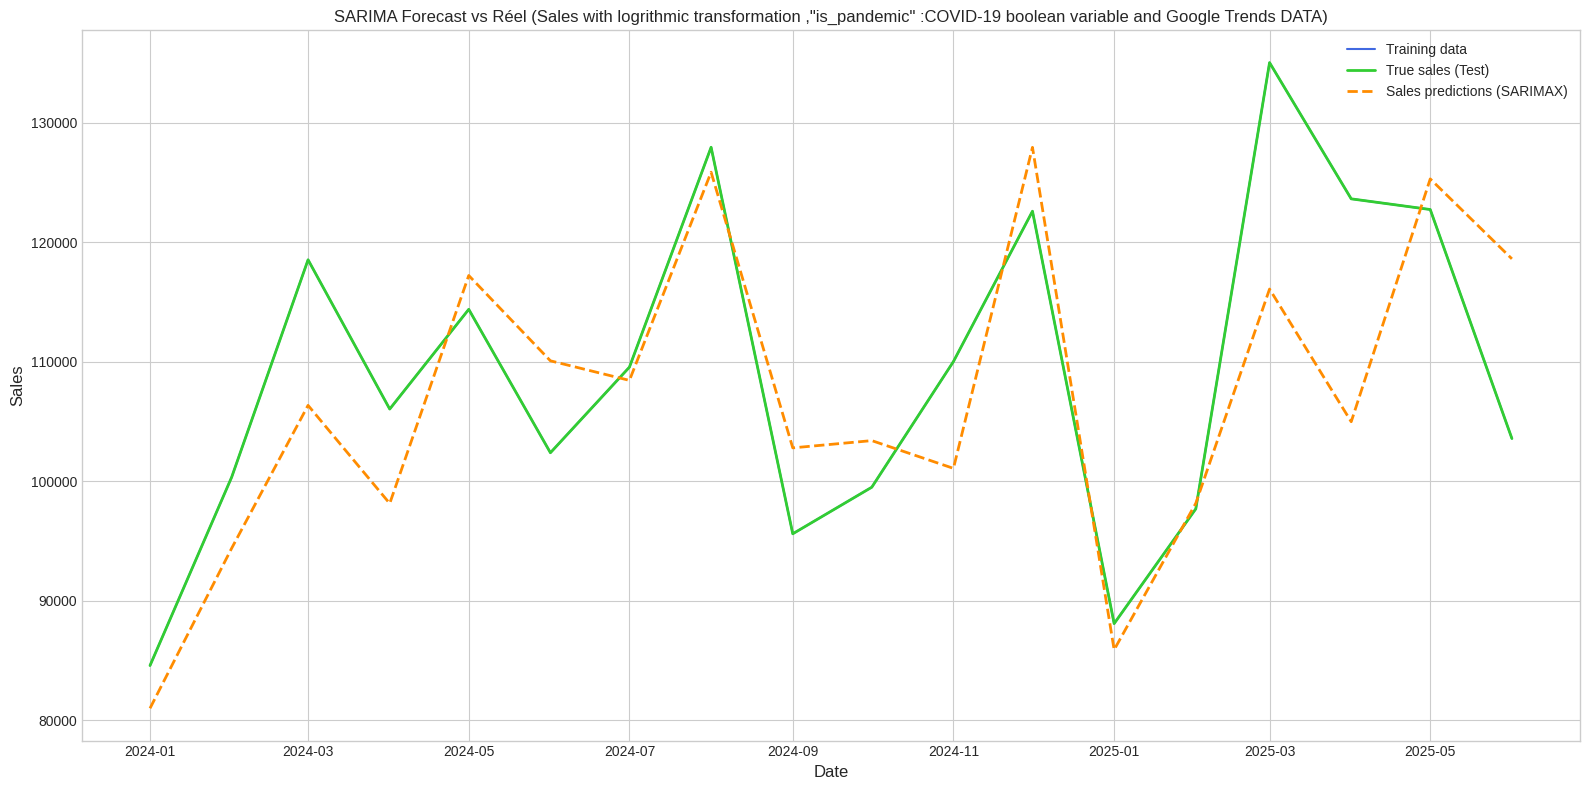

In [ ]:
#logartithmic transformation
df['sales_log'] = np.log(df['sales'] + 1)

#Creation of Exogenous Variables:
 # Variable: is_pandemic =>  To explain COVID-19 effect

pandemic_start = '2020-03-01'
pandemic_end = '2020-12-31'
df['is_pandemic'] = 0
df.loc[pandemic_start:pandemic_end, 'is_pandemic'] = 1

 # Variable: is_crisis_2008 => To explain the financial crisis in 2008
crisis_start = '2008-01-01'
crisis_end = '2009-08-01'
df['is_crisis_2008'] = 0
df.loc[crisis_start:crisis_end, 'is_crisis_2008'] = 1

train_size = int(len(df)-split)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


df['scaled_trend'] = scaler.fit_transform(df[['trend']])



exog_variables = [
                  'is_pandemic',
                  'trend',
                  'is_crisis_2008',
                  #'month',
                  'Tweet_Count',
                  'Avg_Positive_Confidence',
                  'Weighted_Sentiment_Mean',
                  #'Unweighted_Sentiment_Mean'
                  ]



train, test = df.iloc[:train_size], df.iloc[train_size:]


X_train = train[exog_variables]
X_test = test[exog_variables]
y_train = train['sales_log']
y_test = test['sales']

# Model
model = SARIMAX(y_train, exog=train[exog_variables], order=(4,1,1), seasonal_order=(2,1,2,12),)
results = model.fit(disp=False, cov_type='robust', maxiter=100)


start_index = test.index.min()
end_index = test.index.max()
scaled_predictions = results.predict(start=start_index, end=end_index, exog=X_test)
predictions = np.exp(predictions_log) - 1


def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#Evaluation
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = calculate_mape(y_test, predictions)
print(results.summary())
print(f"\nRMSE: {rmse:.2f}")
print(f"\nMAE: {mae:.2f}")
print(f"\nMAPE: {mape:.2f}%")
print(f"\nR²: {r2:.2%}")


#Visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))
plt.plot(test['sales'], label='Training data', color='royalblue')
plt.plot(y_test, label='True sales (Test)', color='limegreen', linewidth=2)
plt.plot(predictions, label='Sales predictions (SARIMAX)', color='darkorange', linestyle='--', linewidth=2)
plt.title('SARIMA Forecast vs Réel (Sales with logrithmic transformation ,"is_pandemic" :COVID-19 boolean variable and Google Trends DATA)')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df

,sales,trend,Avg_Positive_Confidence,Avg_Negative_Confidence,Weighted_Sentiment_Mean,Tweet_Count,Unweighted_Sentiment_Mean,sales_log,is_pandemic,is_crisis_2008,scaled_trend
date,,,,,,,,,,,
2005-03-01,109949.0,65.0,0.000000,-1.000000,-1.000000,1.0,-1.000000,11.607781,0,0,0.533333
2005-04-01,116495.0,65.0,0.000000,-1.000000,-1.000000,1.0,-1.000000,11.665612,0,0,0.533333
2005-05-01,103486.0,76.0,0.000000,-1.000000,-1.000000,1.0,-1.000000,11.547201,0,0,0.680000
2005-06-01,114672.0,82.0,0.000000,-1.000000,-1.000000,1.0,-1.000000,11.649840,0,0,0.760000
2005-07-01,123308.0,78.0,0.000000,-1.000000,-1.000000,1.0,-1.000000,11.722449,0,0,0.706667
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-01,97688.0,67.0,0.991453,-0.550000,0.548077,208.0,0.466346,11.489544,0,0,0.560000
2025-03-01,135040.0,66.0,0.973154,-0.800000,0.441781,292.0,0.321918,11.813334,0,0,0.546667
2025-04-01,123637.0,67.0,1.000000,-0.500000,0.682203,236.0,0.474576,11.725113,0,0,0.560000


                                        SARIMAX Results                                        
Dep. Variable:                               sales_log   No. Observations:                  226
Model:             SARIMAX(4, 1, 1)x(3, 1, [1, 2], 12)   Log Likelihood                 116.464
Date:                                 Sun, 24 Aug 2025   AIC                           -196.929
Time:                                         15:36:01   BIC                           -136.426
Sample:                                     03-01-2005   HQIC                          -172.477
                                          - 12-01-2023                                         
Covariance Type:                                robust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
is_pandemic                -0.3035      0.190   

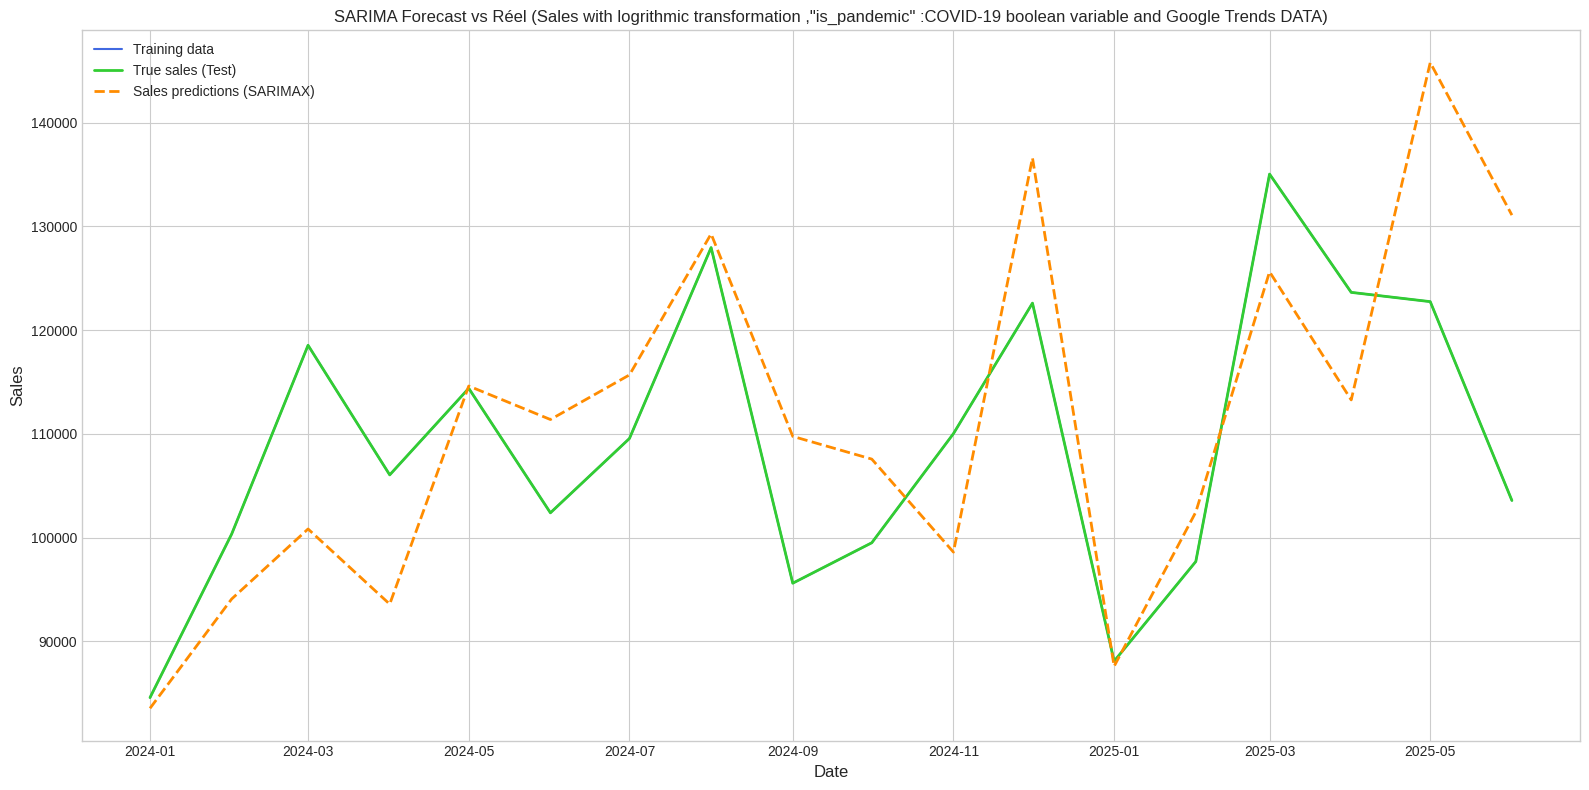

In [ ]:
#logartithmic transformation
df['sales_log'] = np.log(df['sales'] + 1)

s_train_size = int(len(df)-split)

#Creation of Exogenous Variables:
 # Variable: is_pandemic =>  To explain COVID-19 effect

pandemic_start = '2020-03-01'
pandemic_end = '2021-12-31'
df['is_pandemic'] = 0
df.loc[pandemic_start:pandemic_end, 'is_pandemic'] = 1

 # Variable: is_crisis_2008 => To explain the financial crisis in 2008
crisis_start = '2008-01-01'
crisis_end = '2009-08-01'
df['is_crisis_2008'] = 0
df.loc[crisis_start:crisis_end, 'is_crisis_2008'] = 1


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df['scaled_trend'] = scaler.fit_transform(df[['trend']])
df['scaled_tweet_count'] = scaler.fit_transform(df[['Tweet_Count']])

exog_variables = [
                  'is_pandemic',
                  'scaled_trend',
                  'is_crisis_2008',
                  'Tweet_Count',
                  'Avg_Positive_Confidence',
                  'Avg_Negative_Confidence',
                  'Weighted_Sentiment_Mean',
                  #'Unweighted_Sentiment_Mean'
                  ]



train, test = df.iloc[:s_train_size], df.iloc[s_train_size:]


X_train = train[exog_variables]
X_test = test[exog_variables]
y_train = train['sales_log']
y_test = test['sales']

# Model
model = SARIMAX(y_train, exog=train[exog_variables], order=(4,1,1), seasonal_order=(3,1,2,12),)
results = model.fit(disp=False, cov_type='robust', maxiter=100)


start_index = test.index.min()
end_index = test.index.max()
predictions_log = results.predict(start=start_index, end=end_index, exog=X_test)
predictions = np.exp(predictions_log) - 1


def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#Evaluation
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = calculate_mape(y_test, predictions)
print(results.summary())
print(f"\nRMSE: {rmse:.2f}")
print(f"\nMAE: {mae:.2f}")
print(f"\nMAPE: {mape:.2f}%")
print(f"\nR²: {r2:.2%}")


#Visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))
plt.plot(test['sales'], label='Training data', color='royalblue')
plt.plot(y_test, label='True sales (Test)', color='limegreen', linewidth=2)
plt.plot(predictions, label='Sales predictions (SARIMAX)', color='darkorange', linestyle='--', linewidth=2)
plt.title('SARIMA Forecast vs Réel (Sales with logrithmic transformation ,"is_pandemic" :COVID-19 boolean variable and Google Trends DATA)')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# #logartithmic transformation
# df['sales_log'] = np.log(df['sales'] + 1)

# s_train_size = int(len(df)-split)

# #Creation of Exogenous Variables:
#  # Variable: is_pandemic =>  To explain COVID-19 effect

# pandemic_start = '2020-03-01'
# pandemic_end = '2021-12-31'
# df['is_pandemic'] = 0
# df.loc[pandemic_start:pandemic_end, 'is_pandemic'] = 1

#  # Variable: is_crisis_2008 => To explain the financial crisis in 2008
# crisis_start = '2008-01-01'
# crisis_end = '2009-08-01'
# df['is_crisis_2008'] = 0
# df.loc[crisis_start:crisis_end, 'is_crisis_2008'] = 1


# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# df['scaled_trend'] = scaler.fit_transform(df[['trend']])
# df['scaled_tweet_count'] = scaler.fit_transform(df[['Tweet_Count']])

# exog_variables = [
#                   'is_pandemic',
#                   'trend',
#                   'is_crisis_2008',
#                   'Tweet_Count',
#                   'Avg_Positive_Confidence',
#                   'Avg_Negative_Confidence',
#                   'Weighted_Sentiment_Mean',
#                   #'Unweighted_Sentiment_Mean'
#                   ]



# train, test = df.iloc[:s_train_size], df.iloc[s_train_size:]


# X_train = train[exog_variables]
# X_test = test[exog_variables]
# y_train = train['sales_log']
# y_test = test['sales']

# train_history, test_history = train.copy(), test.copy()

# mae_list, mape_list = [], []

# def calculate_mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# def train_sarimax(y, exog):
#   model = SARIMAX(y, exog=exog, order=(4,1,1), seasonal_order=(2,1,2,12),)
#   results = model.fit(disp=False, cov_type='robust', maxiter=100)
#   return results

# def forecast_sarimax(fitted, exog):
#   predictions_log = fitted.forecast(steps=1, exog=exog)
#   predictions = np.exp(predictions_log) - 1
#   return predictions

# predictions_list = []

# x_train_history, y_train_history = df.iloc[:split][exog_variables], df.iloc[:split]['sales_log']
# x_test_history, y_test_history = df.iloc[split:][exog_variables], df.iloc[split:]['sales_log']

# for i in tqdm(range(split)):

#   if i==0:
#     results = train_sarimax(y_train_history, x_train_history)
#     forecast = forecast_sarimax(results, x_test_history[0])
#     mae = mean_absolute_error(y_test_history[i], forecast)
#     mape = calculate_mape(y_test_history[i], forecast)
#     mae_list.append(mae); mape_list.append(mape)
#     predictions_list.append(forecast)
#     next date = y_train_history.index[-1] + pd.Timedelta(months=1)
#     y_train_history.iloc[next_date] = float(forecast)
#   else:
#     train_history = df.iloc[:s_train_size + i]
#     results = train_sarimax(train_history['sales_log'])


#   print(f"===Iterationn {i} results===")
#   print(f"=== MAE:{mae:.2f} --- MAPE: {mape:.2f}")


# # Model
# model = SARIMAX(y_train, exog=train[exog_variables], order=(4,1,1), seasonal_order=(2,1,2,12),)
# results = model.fit(disp=False, cov_type='robust', maxiter=100)


# start_index = test.index.min()
# end_index = test.index.max()
# predictions_log = results.predict(start=start_index, end=end_index, exog=X_test)
# predictions = np.exp(predictions_log) - 1





# #Evaluation
# rmse = root_mean_squared_error(y_test, predictions)
# r2 = r2_score(y_test, predictions)
# mae = mean_absolute_error(y_test, predictions)
# mape = calculate_mape(y_test, predictions)
# print(results.summary())
# print(f"\nRMSE: {rmse:.2f}")
# print(f"\nMAE: {mae:.2f}")
# print(f"\nMAPE: {mape:.2f}%")
# print(f"\nR²: {r2:.2%}")


# #Visualization
# plt.style.use('seaborn-v0_8-whitegrid')
# plt.figure(figsize=(16, 8))
# plt.plot(test['sales'], label='Training data', color='royalblue')
# plt.plot(y_test, label='True sales (Test)', color='limegreen', linewidth=2)
# plt.plot(predictions, label='Sales predictions (SARIMAX)', color='darkorange', linestyle='--', linewidth=2)
# plt.title('SARIMA Forecast vs Réel (Sales with logrithmic transformation ,"is_pandemic" :COVID-19 boolean variable and Google Trends DATA)')
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Sales', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:

from math import sqrt
from itertools import combinations


# Assuming 'df' is your DataFrame with a DatetimeIndex
# For demonstration, let's create a sample DataFrame.
# In your actual use, you would load your data into 'df'.
np.random.seed(0)
date_rng = pd.date_range(start='2005-01-01', end='2022-12-31', freq='MS')
data = np.random.randint(50, 200, size=(len(date_rng)))
df = pd.DataFrame(data, index=date_rng, columns=['sales'])
df['trend'] = np.arange(len(df))
df['Tweet_Count'] = np.random.randint(100, 500, size=(len(df)))
df['Avg_Positive_Confidence'] = np.random.rand(len(df))
df['Avg_Negative_Confidence'] = np.random.rand(len(df))
df['Weighted_Sentiment_Mean'] = np.random.uniform(-1, 1, size=(len(df)))


# Logarithmic transformation
df['sales_log'] = np.log(df['sales'] + 1)

# Define the split point for training and testing data
split = 36 # For example, 36 months for testing
s_train_size = int(len(df) - split)

# Creation of Exogenous Variables:
# Variable: is_pandemic => To explain COVID-19 effect
pandemic_start = '2020-03-01'
pandemic_end = '2021-12-31'
df['is_pandemic'] = 0
df.loc[pandemic_start:pandemic_end, 'is_pandemic'] = 1

# Variable: is_crisis_2008 => To explain the financial crisis in 2008
crisis_start = '2008-01-01'
crisis_end = '2009-08-01'
df['is_crisis_2008'] = 0
df.loc[crisis_start:crisis_end, 'is_crisis_2008'] = 1

# Scale numerical features
scaler = StandardScaler()
df['scaled_trend'] = scaler.fit_transform(df[['trend']])
df['scaled_tweet_count'] = scaler.fit_transform(df[['Tweet_Count']])

# --- MODIFICATION START ---

# Define the fixed variables that will be in every model
# Note: Using the scaled version of 'trend' as in the original code
fixed_exog_variables = [
    'scaled_trend',
    'Avg_Positive_Confidence',
    'Avg_Negative_Confidence',
    'Weighted_Sentiment_Mean'
]

# Define the variables to test in combination
combinable_exog_variables = [
    'is_pandemic',
    'is_crisis_2008',
    'scaled_tweet_count'
]

# --- MODIFICATION END ---


# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate RMSE
def root_mean_squared_error(y_true, y_pred):
    return sqrt(np.mean((y_true - y_pred)**2))


# Store results
results_list = []

# Generate all combinations of the combinable exogenous variables,
# starting from 0 (which means only the fixed variables will be used)
for i in range(len(combinable_exog_variables) + 1):
    for combo in combinations(combinable_exog_variables, i):

        # Add the current combination to the fixed set of variables
        current_exog = fixed_exog_variables + list(combo)

        print(f"Training model with exogenous variables: {current_exog}")

        # Split data
        train, test = df.iloc[:s_train_size], df.iloc[s_train_size:]

        X_train = train[current_exog]
        X_test = test[current_exog]
        y_train = train['sales_log']
        y_test = test['sales']

        try:
            # Model
            model = SARIMAX(y_train, exog=X_train, order=(4, 1, 1), seasonal_order=(2, 1, 2, 12))
            results = model.fit(disp=False, cov_type='robust', maxiter=200)

            # Predictions
            start_index = test.index.min()
            end_index = test.index.max()
            predictions_log = results.predict(start=start_index, end=end_index, exog=X_test)
            predictions = np.exp(predictions_log) - 1

            # Handle potential negative predictions if sales must be non-negative
            predictions[predictions < 0] = 0

            # Evaluation
            rmse = root_mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            mae = mean_absolute_error(y_test, predictions)
            mape = calculate_mape(y_test, predictions)

            # Store results
            results_list.append({
                'Exogenous Variables': ', '.join(current_exog),
                'R2': r2,
                'MAE': mae,
                'MAPE': mape,
                'RMSE': rmse
            })

        except Exception as e:
            print(f"Could not train model with {current_exog}. Error: {e}")
            results_list.append({
                'Exogenous Variables': ', '.join(current_exog),
                'R2': 'Error',
                'MAE': 'Error',
                'MAPE': 'Error',
                'RMSE': 'Error'
            })


# Create a summary table
results_df = pd.DataFrame(results_list)

# Sort the results for better comparison, e.g., by R2 score in descending order
# Convert R2 to numeric, coercing errors to NaN, then fill NaN to handle the 'Error' strings
results_df['R2_numeric'] = pd.to_numeric(results_df['R2'], errors='coerce')
results_df_sorted = results_df.sort_values(by='R2_numeric', ascending=False).drop(columns=['R2_numeric'])


# Display the summary table
print("\n--- Model Performance Summary ---")
print(results_df_sorted.to_string()) # .to_string() ensures the full table is printed

# --- You can uncomment the visualization part to plot the best model ---
# Find the best combination based on R2 score
if not results_df_sorted.empty and results_df_sorted.iloc[0]['R2'] != 'Error':
    best_combo_str = results_df_sorted.iloc[0]['Exogenous Variables']
    best_exog = best_combo_str.split(', ')

    print(f"\nVisualizing the best performing model with variables: {best_exog}")

    # Retrain the best model to plot
    train, test = df.iloc[:s_train_size], df.iloc[s_train_size:]
    X_train_best = train[best_exog]
    X_test_best = test[best_exog]
    y_train = train['sales_log']
    y_test = test['sales']

    model_best = SARIMAX(y_train, exog=X_train_best, order=(4, 1, 1), seasonal_order=(2, 1, 2, 12))
    results_best = model_best.fit(disp=False, cov_type='robust', maxiter=200)

    start_index = test.index.min()
    end_index = test.index.max()
    predictions_log_best = results_best.predict(start=start_index, end=end_index, exog=X_test_best)
    predictions_best = np.exp(predictions_log_best) - 1
    predictions_best[predictions_best < 0] = 0

    # Visualization of the best model
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))
    plt.plot(df['sales'], label='Historical Data', color='royalblue')
    plt.plot(y_test, label='True Sales (Test)', color='limegreen', linewidth=2)
    plt.plot(predictions_best, label='Best Sales Predictions (SARIMAX)', color='darkorange', linestyle='--', linewidth=2)
    plt.title(f'SARIMAX Forecast vs. Actual Sales (Best Model)\nExogenous Variables: {best_combo_str}')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Training model with exogenous variables: ['scaled_trend', 'Avg_Positive_Confidence', 'Avg_Negative_Confidence', 'Weighted_Sentiment_Mean']
Training model with exogenous variables: ['scaled_trend', 'Avg_Positive_Confidence', 'Avg_Negative_Confidence', 'Weighted_Sentiment_Mean', 'is_pandemic']
Training model with exogenous variables: ['scaled_trend', 'Avg_Positive_Confidence', 'Avg_Negative_Confidence', 'Weighted_Sentiment_Mean', 'is_crisis_2008']
Training model with exogenous variables: ['scaled_trend', 'Avg_Positive_Confidence', 'Avg_Negative_Confidence', 'Weighted_Sentiment_Mean', 'scaled_tweet_count']
Training model with exogenous variables: ['scaled_trend', 'Avg_Positive_Confidence', 'Avg_Negative_Confidence', 'Weighted_Sentiment_Mean', 'is_pandemic', 'is_crisis_2008']
Training model with exogenous variables: ['scaled_trend', 'Avg_Positive_Confidence', 'Avg_Negative_Confidence', 'Weighted_Sentiment_Mean', 'is_pandemic', 'scaled_tweet_count']
Training model with exogenous variables: 

KeyboardInterrupt: 

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from tqdm.notebook import tqdm
# from sklearn.linear_model import LinearRegression  # Exemple de modèle

# # --- Configuration ---
# # Assure-toi que df, exog_variables, split et model sont définis avant ce code
# # Exemple:
# # df = ton_dataframe
# # exog_variables = ['feature1', 'feature2']
# # split = 60  # Nombre de jours / mois à utiliser pour le test
# # model = LinearRegression()



# final_results = []
# predictions_for_plot = {}

# # --- Séparation train / test ---
# s_train_size = int(len(df) - split)
# train, test = df.iloc[:s_train_size], df.iloc[s_train_size:]

# X_train = train[exog_variables]
# X_test = test[exog_variables]
# y_train = train['sales_log']
# y_test = test['sales']

# # --- Initialisation de l'historique ---
# X_history = X_train.copy()
# y_history = y_train.copy()
# model_predictions = []

# print(f"\n--- Starting Final Iterative Simulation with 2-Month Lag ---")

# name = "SARIMAX"  # ou le nom de ton modèle

# # --- Boucle de simulation (step-by-step update) ---
# for t in tqdm(range(len(X_test)), desc=f"Forecasting {name}", leave=False):
#     # Point de prévision courant
#     X_forecast_point = X_test.iloc[[t]]  # Double crochet pour garder DataFrame

#     # Fit avec tout l'historique disponible
#     model = SARIMAX(y_history, exog=X_history, order=(4,1,1), seasonal_order=(2,1,2,12))
#     results = model.fit(disp=False, cov_type='robust', maxiter=100)

#     # Prédiction pour le point courant
#     y_pred = results.forecast(steps=1, exog=X_forecast_point)

#     # Sauvegarde la prédiction
#     model_predictions.append(y_pred[0])

#     # Met à jour l'historique avec la prédiction
#     X_history = pd.concat([X_history, X_forecast_point])
#     y_pred_series = pd.Series(y_pred, index=X_forecast_point.index)
#     y_history = pd.concat([y_history, y_pred_series])

# # --- Calcul manuel des métriques ---
# y_true = np.array(y_test)
# y_pred = np.array(model_predictions)

# # MAPE
# mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# # MAE
# mae = np.mean(np.abs(y_true - y_pred))

# # R²
# ss_res = np.sum((y_true - y_pred) ** 2)
# ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
# r2 = 1 - (ss_res / ss_tot)

# # Stockage des résultats
# final_results.append({
#     "Model": name,
#     "Final MAPE (%)": f"{mape:.2f}",
#     "Final MAE": f"{mae:.2f}",
#     "Final R-squared": f"{r2:.2f}"
# })

# # Stockage des prédictions pour le plot
# predictions_for_plot[name] = model_predictions

# # --- Affichage final ---
# results_df = pd.DataFrame(final_results).set_index("Model")
# print("\n\n--- Final Iterative Simulation Performance (Manually Calculated) ---")
# print(results_df.sort_values("Final MAPE (%)"))
